In [28]:
from google.cloud import bigquery
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import calendar
from sklearn.linear_model import LinearRegression
from datetime import datetime
import numpy as np
import calendar

In [2]:
def clean_data(df, min_val, max_val):
    return df[df['energy_demand'].between(min_val, max_val)].set_index('energy_timestamp_mtn')

In [52]:
# define the max and min dates to pull training data from BQ
data_start = datetime(2015, 8, 1)
data_end = datetime(2021, 6, 1)

q = "SELECT * FROM `mlops-zoomcamp-354700.energy_data_prod.joined_temp_and_demand`"
df_raw = pd.read_gbq(q, project_id='mlops-zoomcamp-354700')
df_train_raw = df_raw[df_raw['energy_timestamp_mtn'].between(data_start, data_end)]
             

In [49]:
# make features
df_train = (clean_data(df_train_raw, 2000, 11_000).reset_index()
                                                 .dropna(subset=['energy_demand', 'temp_F'])
                                                 .assign(
                                                        year=lambda df_: df_['energy_timestamp_mtn'].dt.year,
                                                        day_of_year=lambda df_: df_['energy_timestamp_mtn'].dt.day_of_year,
                                                        hour=lambda df_: df_['energy_timestamp_mtn'].dt.hour,
                                                        is_weekend=lambda df_: df_['energy_timestamp_mtn'].dt.day_of_week >= 5, # saturady day_of_week = 5, sunday = 6
                                                        is_summer=lambda df_: df_['energy_timestamp_mtn'].dt.month.between(5, 9, inclusive='both'),
                                                        month=lambda df_: df_['energy_timestamp_mtn'].dt.month,
                                                        temp_F_squared=lambda df_: df_['temp_F'] * df_['temp_F'],                                                        
                                                )
            
                                            .set_index('energy_timestamp_mtn')                                    
          )


for month in calendar.month_name[1:]:
    df_train[month] = pd.to_numeric(df_train.index.month_name == month)



In [104]:
# define start and end of training data for the model
train_start = datetime(2015, 8, 1)
train_end = datetime(2021, 1, 1)
time_filter =  (df_train.index > train_start) & (df_train.index < train_end)

# filter training data
X = df_train.loc[time_filter,
                    ['temp_F', 'year', 'day_of_year', 'hour', 'is_weekend', 'is_summer', 'month', 'temp_F_squared']
                ] 
y = df_train.loc[time_filter, 'energy_demand']

In [105]:
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# predict the training set
X_pred = X.assign(predicted= model.predict(X),
                 energy_demand=y)

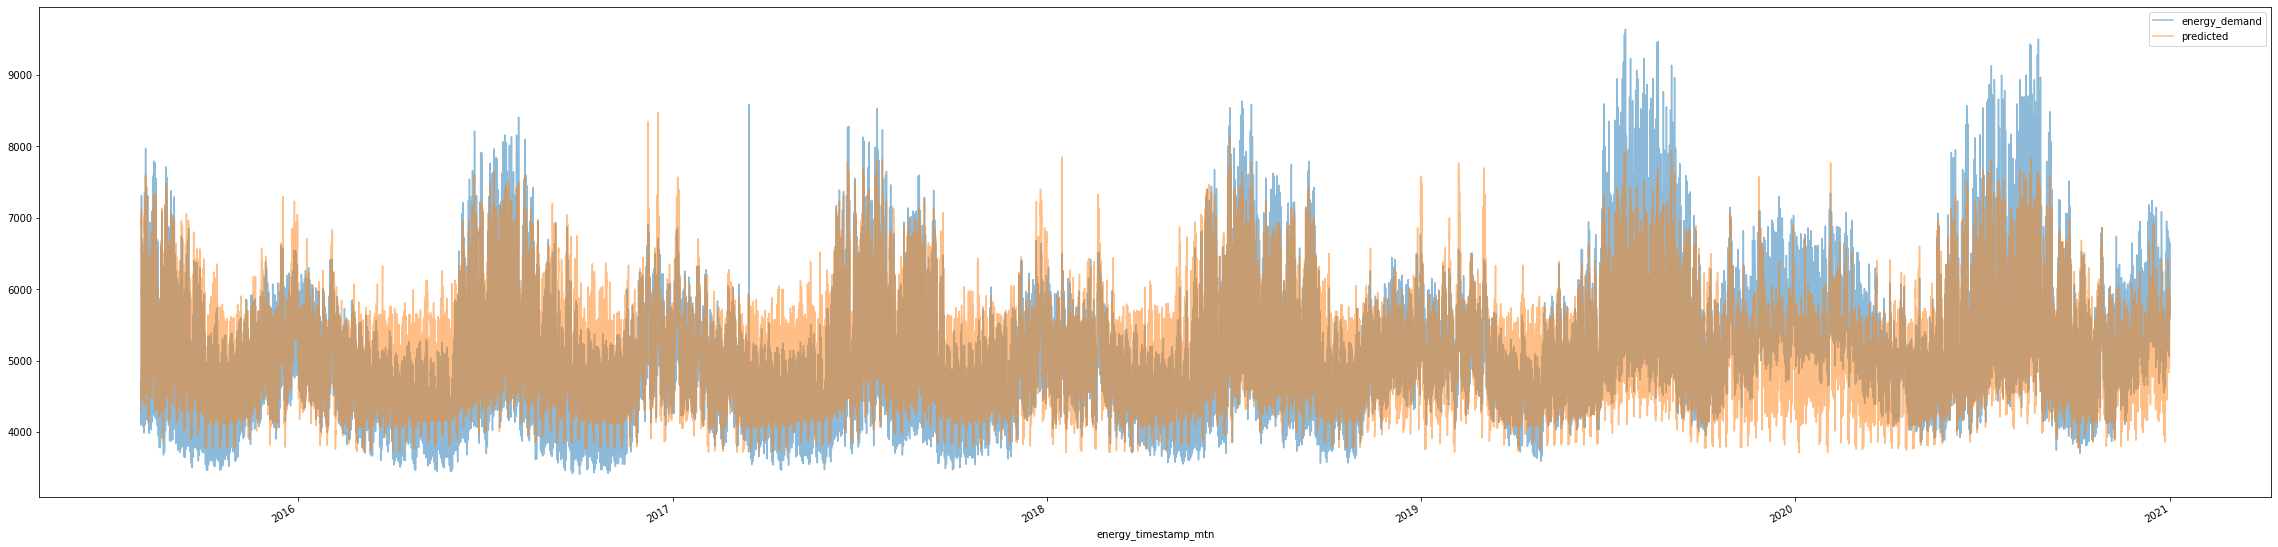

In [76]:
# visualize predicted vs actual on all of training set
X_pred[['energy_demand', 'predicted']].plot(alpha=0.5, figsize=(40,10));

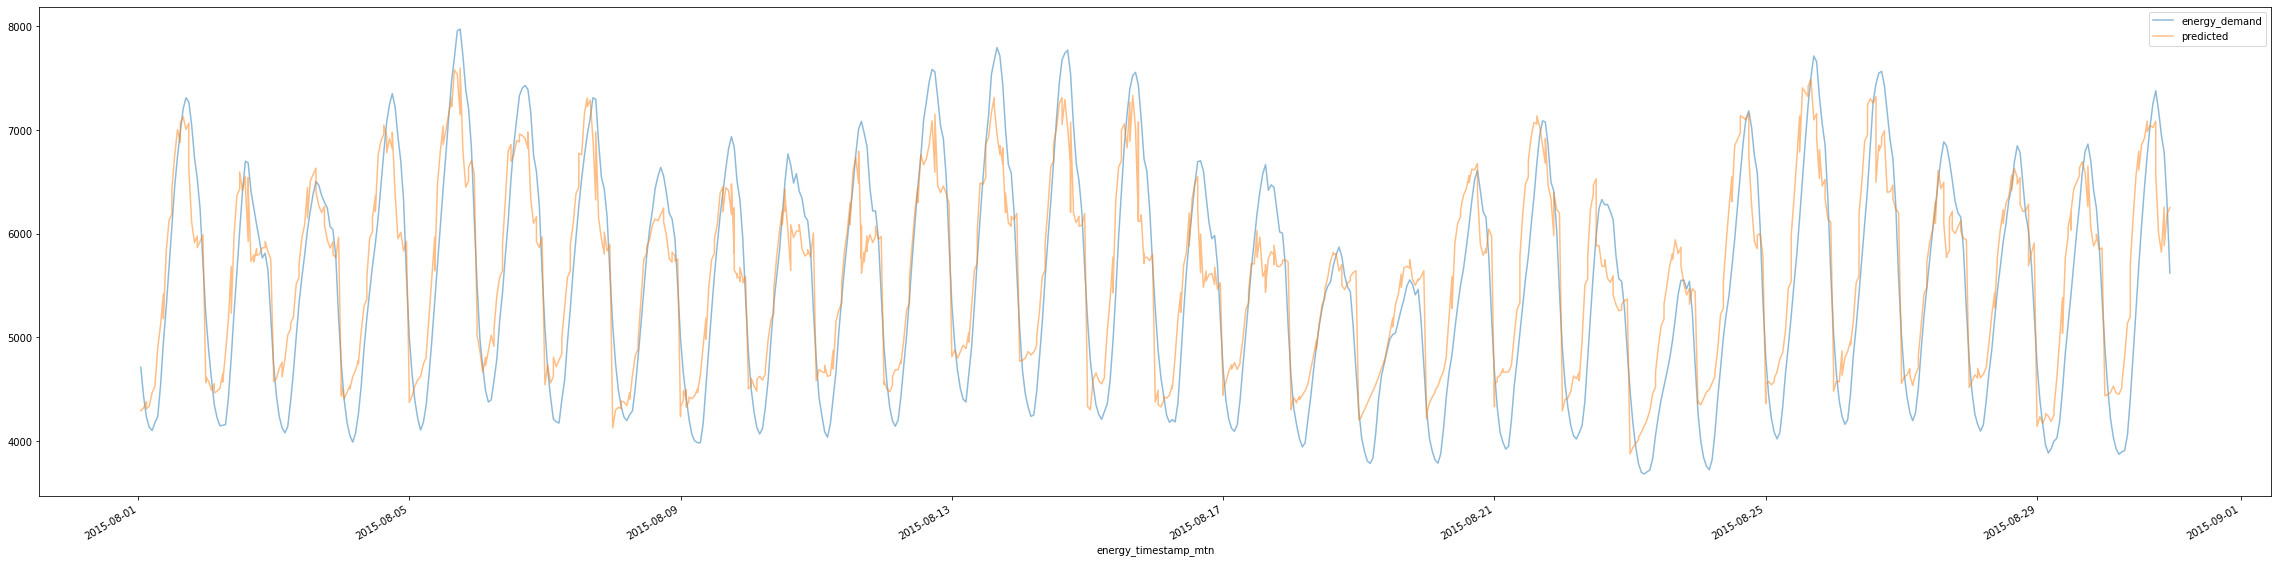

In [78]:
# visualize predicted vs actual on zoomed in portion of the training set
start_time = pd.to_datetime('2015-08-01')
end_time = pd.to_datetime('2015-08-31')

date_filter = (X_pred.index > start_time) &  (X_pred.index < end_time)
X_pred.loc[date_filter, ['energy_demand', 'predicted']].plot(alpha=0.5, figsize=(40,10));

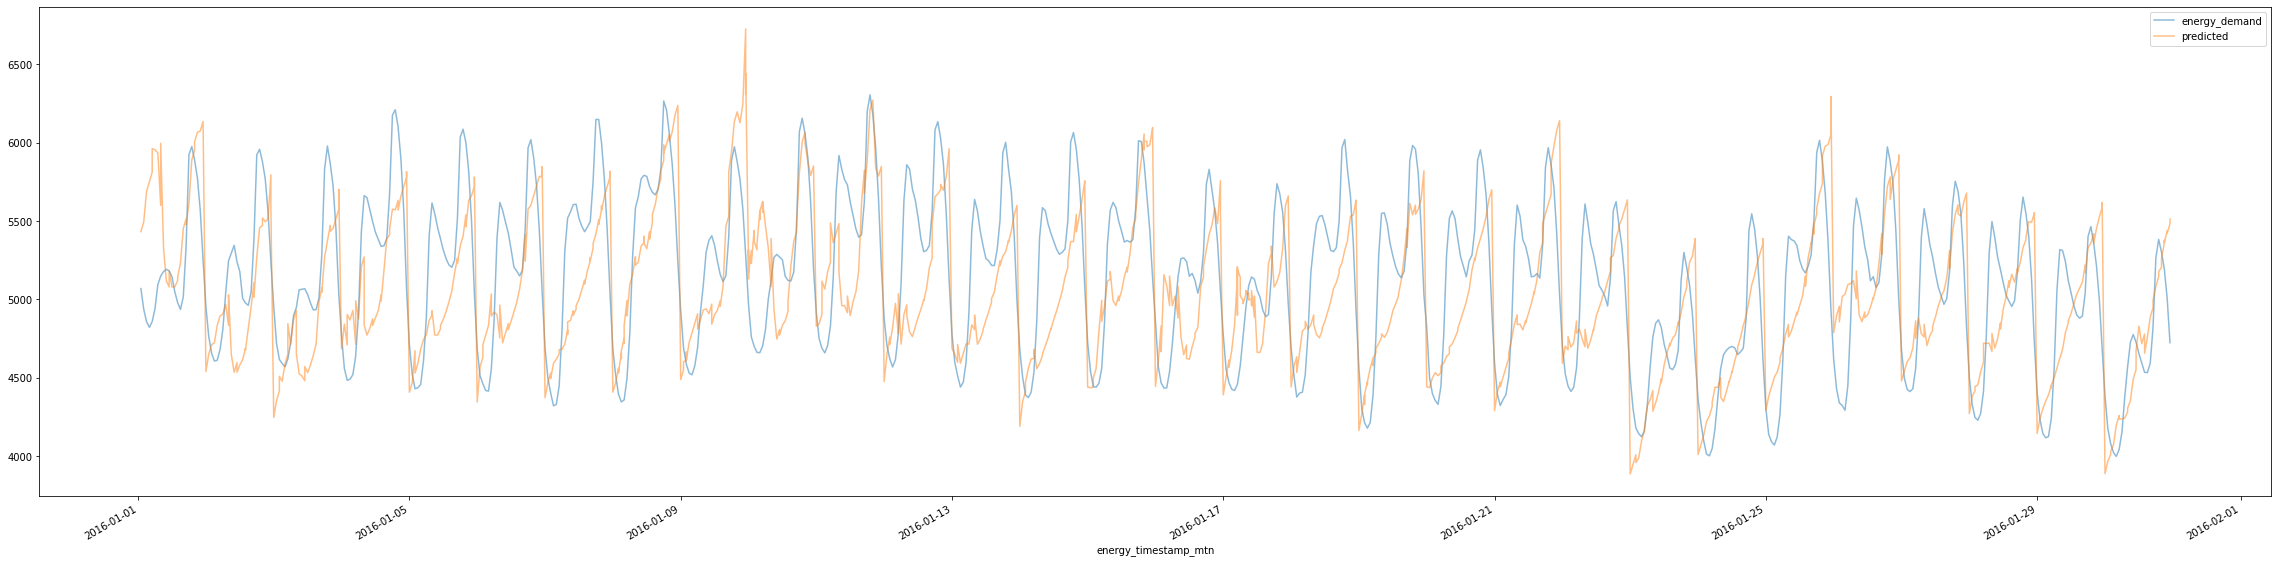

In [48]:
# visualize predicted vs actual on zoomed in portion of the training set
start_time = pd.to_datetime('2016-01-01')
end_time = pd.to_datetime('2016-01-31')

date_filter = (df_train.index > start_time) &  (df_train.index < end_time)
df_train.loc[date_filter, ['energy_demand', 'predicted']].plot(alpha=0.5, figsize=(40,10));

In [106]:
# predict on a range of data not included in the training set
pred_start = datetime(2021, 1, 1)
pred_end = datetime(2021, 6, 1)

time_filter =  (df_train.index > pred_start) & (df_train.index < pred_end)
X = df_train.loc[time_filter,
                    ['temp_F', 'year', 'day_of_year', 'hour', 'is_weekend', 'is_summer', 'month', 'temp_F_squared']
                ] 
y = df_train.loc[time_filter, 'energy_demand']
X_pred_future = X.assign(predicted= model.predict(X),
                 energy_demand=y)


<AxesSubplot:xlabel='energy_timestamp_mtn'>

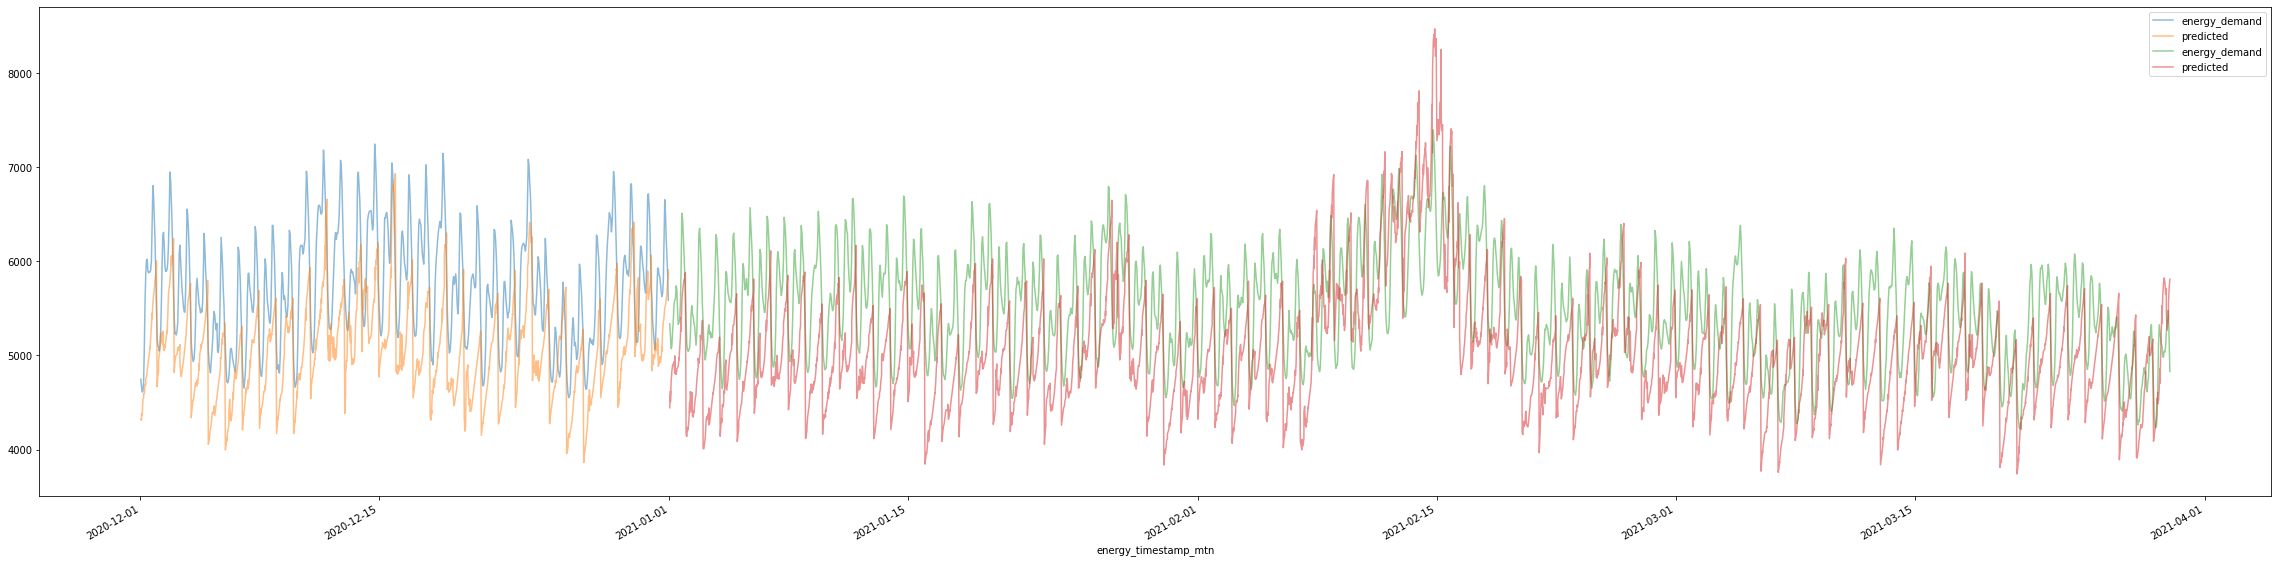

In [103]:
start_time = pd.to_datetime('2020-12-01')
end_time = pd.to_datetime('2021-03-30')

date_filter = (X_pred.index > start_time) &  (X_pred.index < end_time)
ax = X_pred.loc[date_filter, ['energy_demand', 'predicted']].plot(alpha=0.5, figsize=(40,10))
date_filter = (X_pred_future.index > start_time) &  (X_pred_future.index < end_time)
X_pred_future.loc[date_filter, ['energy_demand', 'predicted']].plot(alpha=0.5, figsize=(40,10), ax=ax)